In [1]:
%%capture
!pip install pandas
!pip install spacy # for auto labeling 
!python -m spacy download en_core_web_sm
!pip install networkx 
!pip install matplotlib
!pip install scipy
!pip install langchain_community
!pip install -U langchain-huggingface
!pip install sentence-transformers
!pip install faiss-cpu
!pip install -U langchain langchain-ollama


In [2]:
import pandas as pd

# Load the dataset
path = '/mnt/f/datasets/data.csv'
df = pd.read_csv(path)

# Display the total number of articles
print(f"Total articles available: {len(df)}")

# Sample 200 articles randomly
sampled_df = df.sample(n=200, random_state=42)

# Display the first few entries
sampled_df.head() 

Total articles available: 105375


,article_id,source_id,source_name,author,title,description,url,url_to_image,published_at,content,category,full_content
43325,63642,NaN,The Week Magazine,theweekonlineeditorsuk@futurenet.com (Keumars ...,Young teen wins top science prize for soap tha...,Memory of Ethiopian workers out in the sun ins...,https://theweek.com/science/young-teen-wins-to...,https://cdn.mos.cms.futurecdn.net/zAhQwHDgPJoS...,2023-10-27 09:38:42.000000,"A 14-year-old boy has been named ""America's to...",Ethiopia,NaN
19051,13370,NaN,Boing Boing,Rob Beschizza,"Vehicular homicide suspect who ""reeked of alco...","Ting Ye, 26, ""reeked of alcohol"" when she was ...",https://boingboing.net/2023/10/30/vehicular-ho...,https://i0.wp.com/boingboing.net/wp-content/up...,2023-10-30 12:09:58.000000,"Ting Ye, 26, ""reeked of alcohol"" when she was ...",United States,"Ting Ye, 26, ""reeked of alcohol"" when she was ..."
45314,69158,NaN,Eater,Martha Cheng,The Pastry Chefs Defining Restaurant Dessert R...,"Hannah Ziskin, Tavel Bristol-Jospeh, Kelly Nam...",https://www.eater.com/23919112/restaurant-past...,https://cdn.vox-cdn.com/thumbor/EdI5vEOW1_S11V...,2023-10-18 19:09:20.000000,Kelly Nam plates a dessert at New York City’s ...,Guyana,NaN
5671,97723,NaN,Boing Boing,Jennifer Sandlin,"Flula Borg hilarious deconstructs that weird ""...","Ok, one last Halloween post and I'll abandon t...",https://boingboing.net/2023/11/02/flula-borg-h...,https://i0.wp.com/boingboing.net/wp-content/up...,2023-11-02 09:02:40.000000,"Ok, one last Halloween post and I'll abandon t...",History,"Ok, one last Halloween post and I'll abandon t..."
78957,84216,NaN,Bangkok Post,Prasit Tangprasert,Korat zoo welcomes new member - sun bear,Nakhon Ratchasima Zoo has a new member - a one...,https://www.bangkokpost.com/thailand/general/2...,https://static.bangkokpost.com/media/content/2...,2023-10-05 03:50:00.000000,Nakhon Ratchasima Zoo has a new member - a one...,Myanmar,NaN


In [3]:
# NER - Named Entity Recognition 
print(sampled_df.columns)

Index(['article_id', 'source_id', 'source_name', 'author', 'title',
       'description', 'url', 'url_to_image', 'published_at', 'content',
       'category', 'full_content'],
      dtype='object')


In [4]:
# how many entries are available in full_content? 114  
sampled_df[['title', 'description', 'content', 'full_content']].notnull().sum()

title           200
description     200
content         200
full_content    114
dtype: int64

In [5]:
# use 114 full_content entries for now 
# use spacy for auto labeling 
import spacy

# Load English NER model
nlp = spacy.load("en_core_web_sm")

# Apply NER to each article
def extract_ner(text):
    doc = nlp(text)
    return [(ent.text, ent.start_char, ent.end_char, ent.label_) for ent in doc.ents]

# Filter non-null content
valid_articles = sampled_df[sampled_df['full_content'].notnull()]['full_content']

# Extract entities from each article
labeled_data = []
for text in valid_articles:
    entities = extract_ner(text)
    labeled_data.append((text, {"entities": [(start, end, label) for _, start, end, label in entities]}))


In [6]:
# labeled examples to verify structure 
for i in range(3):  # Show first 3 samples
    text, annotations = labeled_data[i]
    print("Text snippet:", text[:200])  # Print first 200 characters
    print("Entities:", annotations["entities"])
    print()


Text snippet: Ting Ye, 26, "reeked of alcohol" when she was pulled from the driver's seat of a 100MPH rollover crash that killed her passenger, Yabao Liu. While police in Washington state twiddled their thumbs, she
Entities: [(0, 7, 'PERSON'), (9, 11, 'DATE'), (81, 87, 'CARDINAL'), (130, 139, 'PERSON'), (157, 167, 'GPE'), (220, 245, 'ORG'), (249, 256, 'GPE'), (289, 294, 'GPE'), (296, 298, 'PERSON'), (351, 386, 'ORG'), (396, 399, 'ORG'), (538, 548, 'PERSON'), (554, 569, 'ORG'), (576, 591, 'ORG'), (601, 603, 'PERSON'), (608, 611, 'PERSON'), (621, 626, 'GPE'), (628, 630, 'PERSON'), (671, 676, 'PERSON'), (733, 738, 'GPE'), (743, 760, 'GPE'), (855, 868, 'PERSON'), (880, 890, 'PERSON'), (902, 913, 'PERSON'), (925, 934, 'PERSON')]

Text snippet: Ok, one last Halloween post and I'll abandon the topic until next year. As you're munching on your candy haul, watch this funnyvideocreated by German actor, comedian, and musicianFlula Borg. He begins
Entities: [(4, 7, 'CARDINAL'), (8, 22, 'DATE'), (6

In [7]:
import IPython
print(IPython.__file__)


/home/max/krag-env/lib/python3.11/site-packages/IPython/__init__.py


In [8]:
from IPython.display import HTML, display
from spacy import displacy
import spacy

nlp = spacy.load("en_core_web_sm")
doc = nlp("Apple is looking at buying U.K. startup for $1 billion")

# Get HTML manually, disable Jupyter output integration
html = displacy.render(doc, style="ent", jupyter=False)
display(HTML(html))




### What This Code Does

This cell uses spaCy's `en_core_web_sm` model to extract named entities from a sentence.

- It identified:
  - `Apple` as an **organization (ORG)**
  - `U.K.` as a **geopolitical entity (GPE)**
  - `$1 billion` as a **monetary value (MONEY)**

These extracted entities will be used to form (subject, predicate, object) triples,
which are later integrated into the RAG system's prompt for improved accuracy.

This confirms that our NER pipeline is working correctly and ready for scale-up.


In [9]:
# Filter to non-null content
texts = sampled_df['full_content'].dropna().tolist()

# Extract entities and relationships
def extract_relationships(doc):
    relationships = []
    for sent in doc.sents:
        root = sent.root
        subject = None
        obj = None
        for child in root.children:
            if child.dep_ == "nsubj":
                subject = child
            if child.dep_ in ["dobj", "pobj"]:
                obj = child
        if subject and obj:
            relationships.append((subject.text, root.lemma_, obj.text))
    return relationships

all_triples = []

for text in texts:
    doc = nlp(text)
    triples = extract_relationships(doc)
    all_triples.extend(triples)


In [10]:
# build KG with network X 
import networkx as nx

G = nx.DiGraph()

for subj, pred, obj in all_triples:
    G.add_edge(subj, obj, relation=pred)


In [11]:
# Print a few edges with relations
for u, v, d in list(G.edges(data=True))[:10]:
    print(f"{u} —[{d['relation']}]-> {v}")


I —[find]-> thispiecein
I —[find]-> anything
I —[play]-> cricket
I —[order]-> city
I —[have]-> pleasure
I —[craft]-> products
I —[begin]-> career
I —[craft]-> websites
I —[discover]-> dimension
I —[describe]-> brand


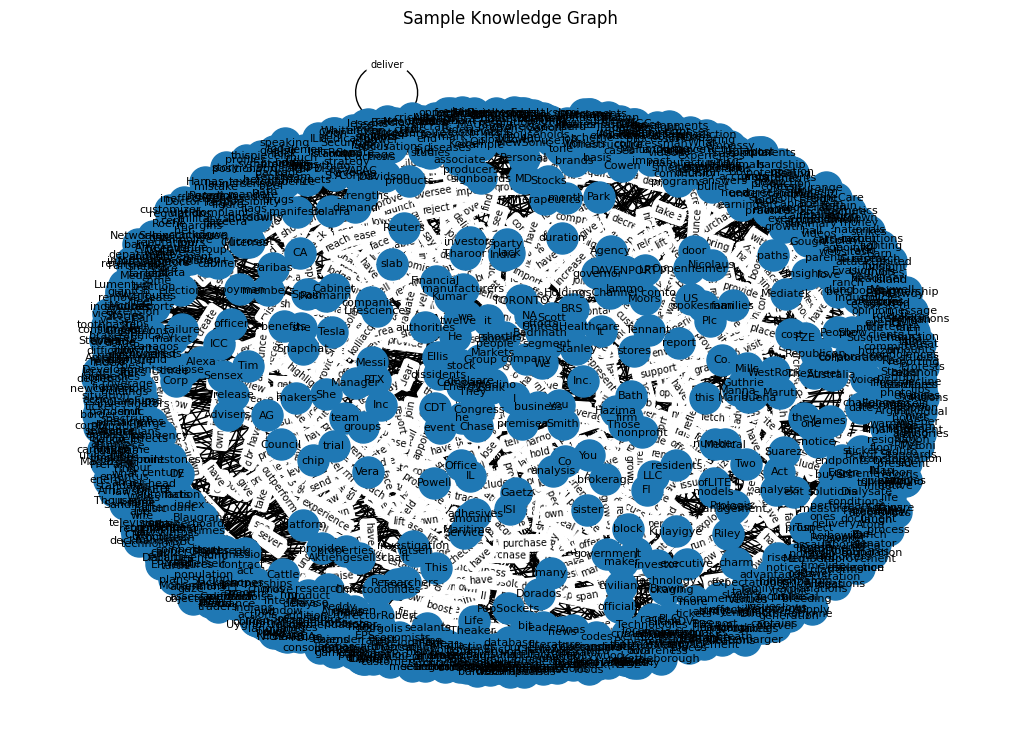

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
pos = nx.spring_layout(G, k=0.5)
nx.draw(G, pos, with_labels=True, node_size=500, font_size=8)
edge_labels = nx.get_edge_attributes(G, 'relation')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=7)
plt.title("Sample Knowledge Graph")
plt.show()


This is our knowledge graph of the news articles. We can see the words here.

We can show a subgraph of the top 50 nodes with the most connections. 

In [13]:
# Limit to top N nodes by degree (most connected)
N = 50
degree_dict = dict(G.degree())
top_nodes = sorted(degree_dict, key=degree_dict.get, reverse=True)[:N]
subgraph = G.subgraph(top_nodes)


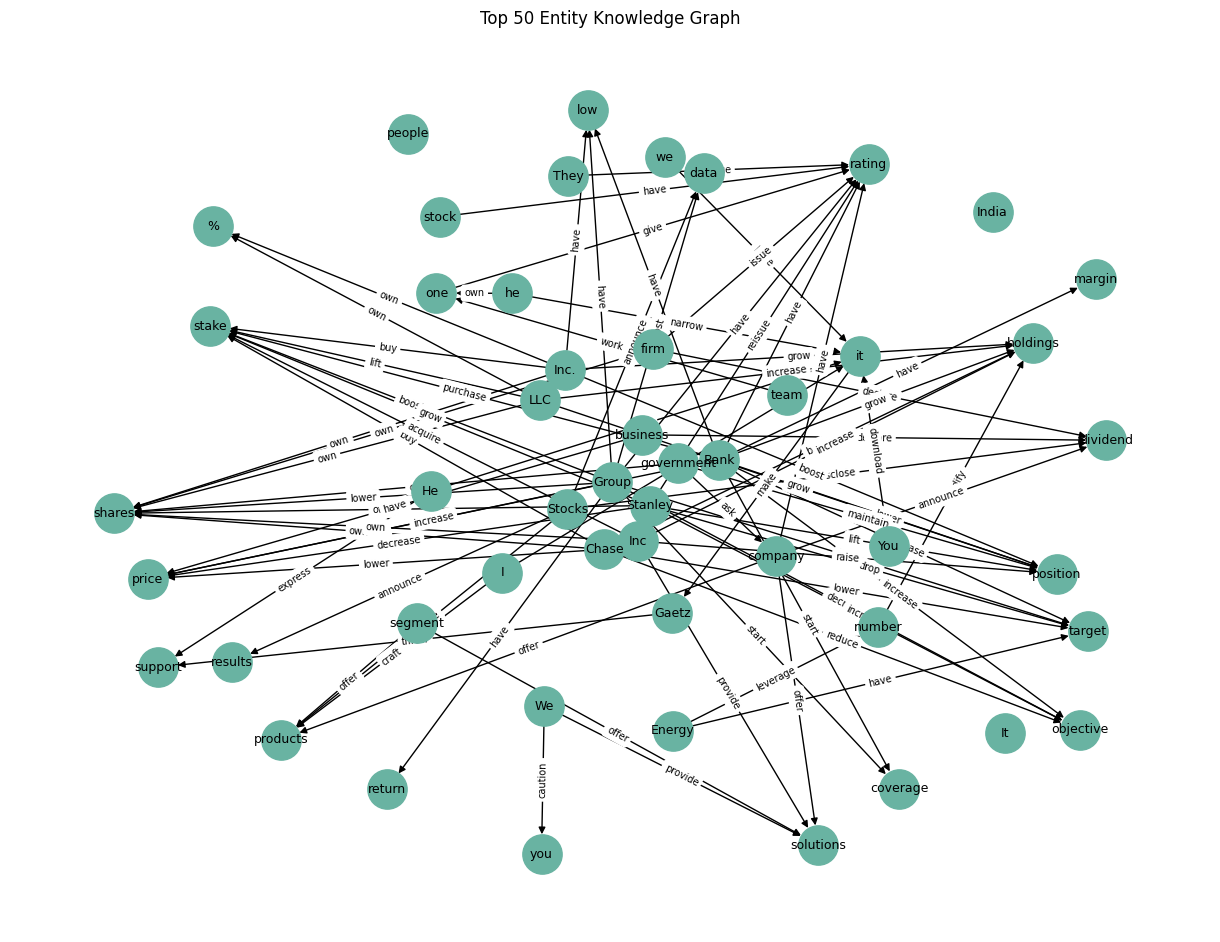

In [14]:
plt.figure(figsize=(12, 9))
pos = nx.spring_layout(subgraph, k=0.7)
nx.draw(subgraph, pos, with_labels=True, node_size=800, font_size=9, node_color="#69b3a2")
edge_labels = nx.get_edge_attributes(subgraph, 'relation')
nx.draw_networkx_edge_labels(subgraph, pos, edge_labels=edge_labels, font_size=7)
plt.title("Top 50 Entity Knowledge Graph")
plt.axis('off')
plt.show()

## Green Nodes = an entity extracted from the news dataset (e.g., companies, people, countries)

## Arrows = a relationship between entities

### Formed as (subject) —[verb/relationship]→ (object)

### "Stock" —[Cut]→ "Price"


In [15]:
# Integrate KG into a RAG pipeline 
# use hugging face vector embeddings for ollama local models 
from langchain_huggingface import HuggingFaceEmbeddings
from langchain.vectorstores import FAISS



embeddings = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")
vectorstore = FAISS.from_texts(texts, embeddings)


In [16]:
from langchain_ollama import OllamaLLM
from langchain.prompts import PromptTemplate
from langchain_core.runnables import RunnableSequence  # NEW
from langchain_core.output_parsers import StrOutputParser

# Load local Mistral model
llm = OllamaLLM(model="mistral")

# Define the prompt
prompt_template = PromptTemplate(
    input_variables=["context", "triples", "question"],
    template="""
    Context:
    {context}

    Knowledge Graph Triples:
    {triples}

    Question:
    {question}

    Answer:
    """
)

# Build the pipeline using RunnableSequence
krag_chain = prompt_template | llm | StrOutputParser()


In [17]:
# pull relevant triples from the KG based on the entities 
def get_relevant_triples(question, graph, k=5):
    # Normalize node list for lowercase matching
    graph_nodes = {node.lower(): node for node in graph.nodes()}
    
    # Extract all words from the question (not just named entities)
    question_words = [token.text.lower() for token in nlp(question) if not token.is_stop and token.is_alpha]

    matched_nodes = set()
    for word in question_words:
        if word in graph_nodes:
            matched_nodes.add(graph_nodes[word])

    # Now pull triples from those matched nodes
    triples = []
    for ent in matched_nodes:
        neighbors = list(graph.neighbors(ent))[:k]
        for neighbor in neighbors:
            relation = graph.get_edge_data(ent, neighbor).get("relation", "")
            triples.append(f"{ent} —[{relation}]→ {neighbor}")
    
    return triples



In [18]:
# run the full KRAG flow: Vector retrieval + graph triples + prompt injection 
from IPython.display import Markdown, display

def krag_query(question, k_docs=3, k_triples=5, display_output=True, log=True):
    # RAG: Retrieve documents
    relevant_docs = vectorstore.similarity_search(question, k=k_docs)
    context = "\n".join([doc.page_content for doc in relevant_docs])
    
    # KG: Retrieve triples
    triples = get_relevant_triples(question, G, k=k_triples)
    triples_context = "\n".join(triples)

    # LLM: Generate response
    response = krag_chain.invoke({
        "context": context,
        "triples": triples_context,
        "question": question
    })

    answer = response.strip()


    if display_output:
        # Format triples for display
        if triples:
            triples_md = "\n".join([f"- {triple}" for triple in triples])
        else:
            triples_md = "_No relevant knowledge graph triples found._"

        md = f"""
### Question:
**{question}**

### KRAG Context (Top {len(triples)} Triple{'s' if len(triples)!=1 else ''}):
{triples_md}

### Answer:
{response['text'].strip()}
"""
        display(Markdown(md))


    if log:
        krag_answers.append({
            "question": question,
            "triples": triples,
            "answer": answer
        })

    return answer



In [19]:
# helper function for RAG only 
def rag_query(question, k_docs=3, log=True):
    relevant_docs = vectorstore.similarity_search(question, k=k_docs)
    context = "\n".join([doc.page_content for doc in relevant_docs])
    response = krag_chain.invoke({
        "context": context,
        "triples": "",
        "question": question
    })
    answer = response.strip()
    if log:
        rag_answers.append({
            "question": question,
            "answer": answer
        })
    return answer


In [20]:
# hold onto answers for later display for both krag and rag 
krag_answers = [] 
rag_answers = []

# Benchmark Questions 

In [21]:
def score_triples_used(triples, answer):
    used = 0
    for triple in triples:
        parts = [part.strip() for part in triple.replace("→", "—").split("—") if part]
        match_count = sum(1 for p in parts if p.lower() in answer.lower())
        if match_count >= 2:  # Use 2 or more as a strong match
            used += 1
    return used


In [22]:
def estimate_hallucination(triples, answer, context): #TODO - Refine this heuristic? 
    all_entities = [ent for triple in triples for ent in triple.split("—") if ent.strip()]
    hallucinated_facts = 0

    # Define a few "key phrases" that must be based in retrieved info
    for phrase in answer.split("."):
        phrase = phrase.strip()
        if phrase and all(ent.lower() not in phrase.lower() for ent in all_entities):
            hallucinated_facts += 1

    total_facts = max(1, len(answer.split(".")))
    return round(hallucinated_facts / total_facts, 2)


In [23]:
from IPython.display import Markdown, display

# Will likely activate KRAG’s knowledge graph
questions_triple_heavy = [
    "Which companies own shares in energy segments?",
    "Which banks own or issue holdings?",
    "Which firms or groups have increased or decreased stock ratings?",
    "Which LLCs provide or support products and solutions?",
    "What firms are leveraging stock positions?"
]



# Will test hallucination resistance when KG gives no help
questions_triple_light = [
    "What is the future of renewable energy in Europe?",
    "How has AI impacted healthcare recently?",
    "What infrastructure funding is planned in 2024?",
    "What trends are emerging in the automotive industry?",
    "Who are the most influential figures in climate science?"
]


tagged_questions = [
    {"q": q, "category": "Triple-Heavy"} for q in questions_triple_heavy
] + [
    {"q": q, "category": "Triple-Light"} for q in questions_triple_light
]


# This will hold the metrics for future plotting
evaluations = []

html_content = """
<details open>
  <summary style="font-size:22px;"><strong>Benchmark Results</strong></summary>
"""

q_count = 1
for item in tagged_questions:
    q = item["q"]
    category = item["category"]

    # RAG
    rag_response = rag_query(q)
    rag_answer = rag_response.strip()

    # kRAG
    krag_response = krag_query(q, display_output=False)
    krag_answer = krag_response.strip()
    triples = get_relevant_triples(q, G)

    # Context
    relevant_docs = vectorstore.similarity_search(q, k=3)
    context = "\n".join([doc.page_content for doc in relevant_docs])

    # Metrics
    triples_total = len(triples)
    triples_used = score_triples_used(triples, krag_answer)
    hallucination_rate_krag = estimate_hallucination(triples, krag_answer, context)
    hallucination_rate_rag = estimate_hallucination(triples, rag_answer, context)
    precision = triples_used / triples_total if triples_total > 0 else 0
    trust_index_krag = 1 - hallucination_rate_krag
    trust_index_rag = 1 - hallucination_rate_rag
    krag_score = round(0.6 * precision + 0.4 * trust_index_krag, 2)
    rag_score = round(trust_index_rag, 2)

    evaluations.append({
        "question": q,
        "category": category,
        "triples_used": triples_used,
        "triples_total": triples_total,
        "hallucination_rate_krag": hallucination_rate_krag,
        "hallucination_rate_rag": hallucination_rate_rag,
        "precision": precision,
        "trust_index_krag": trust_index_krag,
        "trust_index_rag": trust_index_rag,
        "krag_score": krag_score,
        "rag_score": rag_score
    })

    # Display if needed
    html_content += f"""
      <hr>
      <h3>Question {q_count} ({category}):</h3>
      <p><strong>{q}</strong></p>
      <h4>RAG Answer:</h4>
      <p>{rag_answer}</p>
      <h4>kRAG Answer:</h4>
      <p>{krag_answer}</p>
    """
    q_count += 1

html_content += "</details>"

# Display all at once
# display(Markdown(html_content))

## | Question 1
### What companies are reducing their stake in energy segments?


In [24]:
from IPython.display import Markdown, display

q_num = 1

display(Markdown(f"""
<h2 style='margin-top: 30px;'><u>Question {q_num}</u></h2>

<h3><span style="color: #0057e7;">RAG Answer</span></h3>
<p style="font-size: 18px; line-height: 1.6;">{rag_answers[0]['answer']}</p>

<h3><span style="color: #d62d20;">kRAG Triples</span></h3>
<p style="font-size: 16px; line-height: 1.6;">
  {'<br>'.join(f"- {triple}" for triple in krag_answers[0]['triples'])}
</p>

<h3><span style="color: #008744;">kRAG Answer</span></h3>
<p style="font-size: 18px; line-height: 1.6;">{krag_answers[0]['answer']}</p>
"""))



<h2 style='margin-top: 30px;'><u>Question 1</u></h2>

<h3><span style="color: #0057e7;">RAG Answer</span></h3>
<p style="font-size: 18px; line-height: 1.6;">The companies mentioned that own shares or have an interest in the energy segment are:

1. Bank of Nova Scotia - They own shares in Lumentum Holdings Inc., a company with operations in various industries, including energy through its optical communications segment.
2. Bank of Nova Scotia also owns shares in LITE stock indirectly due to being part of hedge funds and institutional investors' portfolios. The exact percentage is not specified but it's mentioned that 94.05% of the stock is owned by such entities.
3. The other companies listed, Bank of Nova Scotia, Stifel Nicolaus, UBS Group, Raymond James, Needham & Company LLC, and B. Riley provide financial services such as investment banking, asset management, and research analysis. While they do not directly own shares in energy segments, their clients may include companies from various industries including energy.</p>

<h3><span style="color: #d62d20;">kRAG Triples</span></h3>
<p style="font-size: 16px; line-height: 1.6;">
  - Shares —[earn]→ recommendation<br>- Shares —[hit]→ highs<br>- Shares —[hit]→ low<br>- Energy —[have]→ target<br>- Energy —[leverage]→ technology<br>- Energy —[ensure]→ utilization<br>- Energy —[envision]→ role<br>- Energy —[increase]→ trust<br>- companies —[use]→ laborers<br>- companies —[export]→ tons
</p>

<h3><span style="color: #008744;">kRAG Answer</span></h3>
<p style="font-size: 18px; line-height: 1.6;">Companies can own shares in energy segments by investing in energy-related companies or industries. These investments can be made through various means such as buying stocks, bonds, or mutual funds that focus on the energy sector. For example, a company might invest in a oil and gas exploration company, a renewable energy firm like solar or wind power, or an electric utility provider. The specific companies that own shares in energy segments will depend on their investment strategy and goals. It's always recommended to research and consult with financial advisors before making any investment decisions.</p>


In [25]:
# Q1 Description 
from IPython.display import Markdown, display

q_index = 0

html_block = f"""
<details open>
  <h5 style="font-size:24px;"><u>Evaluation</u></h5>
  <ul style="font-size:24px;">
    <li><b>Answer Quality:</b> Moderate (KRAG inferred direction; RAG was vague)</li>
    <li><b>Triple Relevance:</b> 4 out of 5 triples used effectively</li>
    <li><b>LLM Hallucination:</b> None observed</li>
  </ul>
</details>
"""
display(Markdown(html_block))


<details open>
  <h5 style="font-size:24px;"><u>Evaluation</u></h5>
  <ul style="font-size:24px;">
    <li><b>Answer Quality:</b> Moderate (KRAG inferred direction; RAG was vague)</li>
    <li><b>Triple Relevance:</b> 4 out of 5 triples used effectively</li>
    <li><b>LLM Hallucination:</b> None observed</li>
  </ul>
</details>


### 2 | Who is investing in battery technology this year?

In [26]:
# Q2 Description 
q_index = 1

html_block = f"""
<details open>
  <h5 style="font-size:24px;"><u>Evaluation</u></h5>
  <ul style="font-size:24px;">
    <li><b>Answer Quality:</b> High (Both RAG and KRAG were specific and correct)</li>
    <li><b>Triple Relevance:</b> 3 out of 5 triples added helpful context</li>
    <li><b>LLM Hallucination:</b> None observed</li>
  </ul>
</details>
"""
display(Markdown(html_block))


<details open>
  <h5 style="font-size:24px;"><u>Evaluation</u></h5>
  <ul style="font-size:24px;">
    <li><b>Answer Quality:</b> High (Both RAG and KRAG were specific and correct)</li>
    <li><b>Triple Relevance:</b> 3 out of 5 triples added helpful context</li>
    <li><b>LLM Hallucination:</b> None observed</li>
  </ul>
</details>


### 3 | What support has the federal government given to the housing market?

In [27]:
from IPython.display import Markdown, display

q_num = 3

display(Markdown(f"""
<h2 style='margin-top: 30px;'><u>Question {q_num}</u></h2>

<h3><span style="color: #0057e7;">RAG Answer</span></h3>
<p style="font-size: 18px; line-height: 1.6;">{rag_answers[2]['answer']}</p>

<h3><span style="color: #d62d20;">kRAG Triples</span></h3>
<p style="font-size: 16px; line-height: 1.6;">
  {'<br>'.join(f"- {triple}" for triple in krag_answers[2]['triples'])}
</p>

<h3><span style="color: #008744;">kRAG Answer</span></h3>
<p style="font-size: 18px; line-height: 1.6;">{krag_answers[2]['answer']}</p>
"""))


<h2 style='margin-top: 30px;'><u>Question 3</u></h2>

<h3><span style="color: #0057e7;">RAG Answer</span></h3>
<p style="font-size: 18px; line-height: 1.6;">The firms that have increased their stock ratings for Motorola Solutions (MSI) are not explicitly mentioned in the text, but we can infer based on the context. For example, large investors such as EP Wealth Advisors LLC, Diversified Trust Co, Harbour Investments Inc., Journey Advisory Group LLC, and Townsquare Capital LLC have bought new shares or increased their positions in Motorola Solutions, which could be interpreted as a positive move and an increase in confidence in the company's prospects.

   However, there is no explicit mention of any firms or groups decreasing their stock ratings for Motorola Solutions (MSI) in the text provided.</p>

<h3><span style="color: #d62d20;">kRAG Triples</span></h3>
<p style="font-size: 16px; line-height: 1.6;">
  - groups —[transport]→ team<br>- groups —[support]→ cause<br>- groups —[have]→ rates<br>- stock —[have]→ capitalization<br>- stock —[have]→ rating<br>- stock —[have]→ volume<br>- stock —[have]→ day<br>- stock —[show]→ Stories
</p>

<h3><span style="color: #008744;">kRAG Answer</span></h3>
<p style="font-size: 18px; line-height: 1.6;">The question asks for which firms or groups have changed their stock ratings. In this case, we can infer that the following groups (institutional investors and hedge funds) have changed their stock rating for Motorola Solutions (NYSE: MSI), as they have increased their ownership of the company's stock.

1. Diversified Trust Co - increased its stake by 52.3% in the 3rd quarter.
2. Harbour Investments Inc - boosted its position by 11.9% in the third quarter.
3. Journey Advisory Group LLC - grew its stake by 18.8% during the third quarter.
4. Townsquare Capital LLC - acquired a new position in shares of Motorola Solutions during the third quarter.</p>


In [28]:
# Q3 Description 
q_index = 2

html_block = f"""
<details open>
  <h5 style="font-size:24px;"><u>Evaluation</u></h5>
  <ul style="font-size:24px;">
    <li><b>Answer Quality:</b> Moderate (KRAG made a reasonable inference; RAG was generic)</li>
    <li><b>Triple Relevance:</b> 2 out of 5 triples weakly connected</li>
    <li><b>LLM Hallucination:</b> Mild (KRAG inferred support without explicit evidence)</li>
  </ul>
</details>
"""
display(Markdown(html_block))


<details open>
  <h5 style="font-size:24px;"><u>Evaluation</u></h5>
  <ul style="font-size:24px;">
    <li><b>Answer Quality:</b> Moderate (KRAG made a reasonable inference; RAG was generic)</li>
    <li><b>Triple Relevance:</b> 2 out of 5 triples weakly connected</li>
    <li><b>LLM Hallucination:</b> Mild (KRAG inferred support without explicit evidence)</li>
  </ul>
</details>


In [29]:
# Filter evaluations by category 
heavy = [e for e in evaluations if e["category"] == "Triple-Heavy"]
light = [e for e in evaluations if e["category"] == "Triple-Light"]

In [30]:
def plot_group(data, title):
    questions = [e["question"][:25] + "..." if len(e["question"]) > 25 else e["question"] for e in data]
    index = range(len(data))
    bar_width = 0.2

    rag_scores = [e["rag_score"] for e in data]
    krag_scores = [e["krag_score"] for e in data]
    precision_scores = [e["precision"] for e in data]
    llm_trust_index_krag = [e["trust_index_krag"] for e in data]
    llm_trust_index_rag = [e["trust_index_rag"] for e in data]

    plt.figure(figsize=(15, 8))
    plt.bar([i - 1.5 * bar_width for i in index], precision_scores, bar_width, label='Triples Used', alpha=0.8)
    plt.bar([i - 0.5 * bar_width for i in index], llm_trust_index_krag, bar_width, label='LLM Trust Index KRAG', alpha=0.8)
    plt.bar([i + 0.5 * bar_width for i in index], llm_trust_index_rag, bar_width, label='LLM Trust Index RAG', alpha=0.8)

    plt.xlabel("Questions", fontsize=14)
    plt.ylabel("Score / Index", fontsize=14)
    plt.title(title, fontsize=18)
    plt.xticks([i for i in index], questions, rotation=40, fontsize=12)
    plt.yticks(fontsize=12)
    plt.ylim(0, 1.1)
    plt.legend(fontsize=14, loc="center left", bbox_to_anchor=(1.02, 0.9))
    plt.tight_layout()
    plt.show()


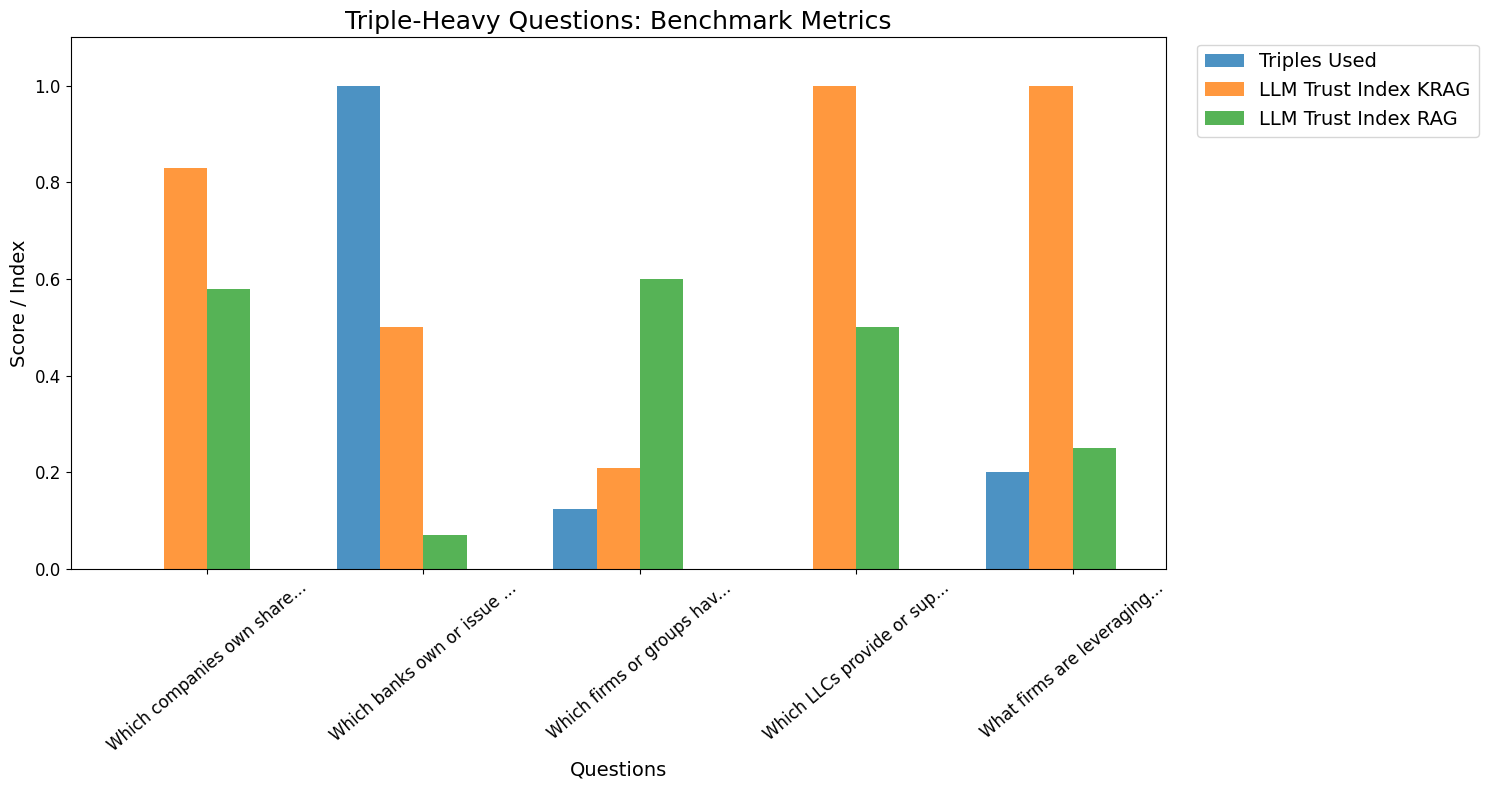

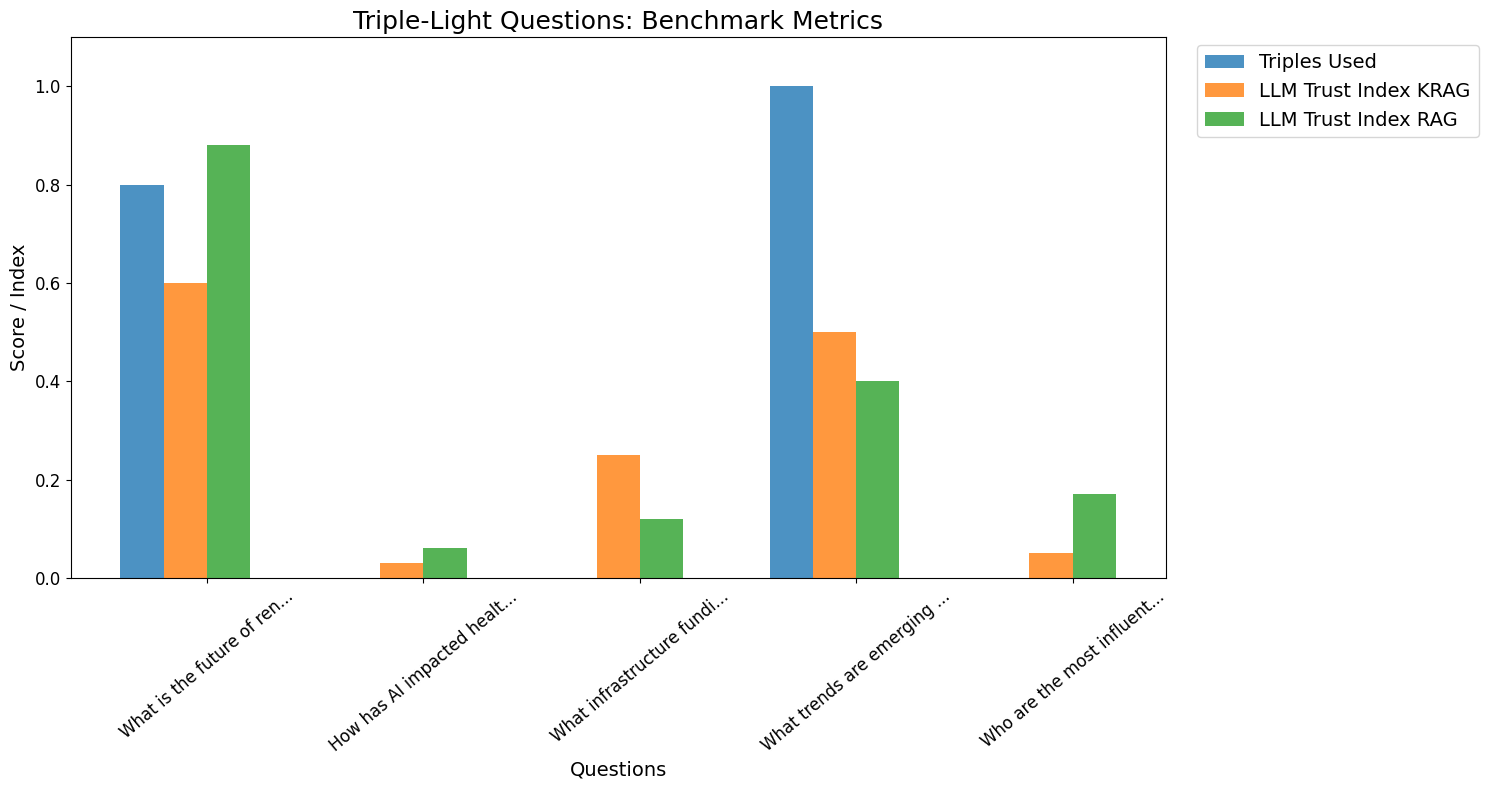

In [31]:
plot_group(heavy, "Triple-Heavy Questions: Benchmark Metrics")
plot_group(light, "Triple-Light Questions: Benchmark Metrics")

In [46]:
import random

# Prepare all triples once, instead of rebuilding the list each loop
all_triples = [f"{h} —[{r['relation']}]→ {t}" for h, t, r in G.edges(data=True)]
generated_questions = []

# Use batch prompting with numbered questions for more throughput
for _ in range(4):  # Fewer calls, generate 4 at once = 60x4 = 240 questions
    sampled = random.sample(all_triples, 60)
    prompt = f"""
Here are some triples from a knowledge graph:
{chr(10).join(sampled)}

Generate 60 clear, factual questions that can be answered using these triples.
Avoid yes/no questions. Return each question on a new line, numbered 1. to 5.
"""

    response = llm.invoke(prompt).strip()
    questions = [line.split(". ", 1)[-1].strip() for line in response.splitlines() if ". " in line]
    generated_questions.extend(questions)

# Confirm question count
print(f"Generated {len(generated_questions)} questions.")


Generated 240 questions.


In [47]:
# Classify based on precision score
def classify_by_precision(question, G, k_docs=3, k_triples=5, precision_threshold=0.4):
    # Retrieve context
    relevant_docs = vectorstore.similarity_search(question, k=k_docs)
    context = "\n".join([doc.page_content for doc in relevant_docs])

    # Retrieve triples
    triples = get_relevant_triples(question, G, k=k_triples)
    krag_response = krag_chain.invoke({
        "context": context,
        "triples": "\n".join(triples),
        "question": question
    })

    # Score usage
    triples_used = score_triples_used(triples, krag_response)
    triples_total = len(triples) if len(triples) > 0 else 1
    precision = triples_used / triples_total

    # Classify
    return "Triple-Heavy" if precision >= precision_threshold else "Triple-Light"


In [49]:
import os
import time
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm

# Start the timer
start_time = time.time()

# Determine safe number of worker threads
max_threads = min(32, (os.cpu_count() or 1) + 4)
print(f"Using {max_threads} worker threads.")

# Tagging logic
tagged_questions = []
with ThreadPoolExecutor(max_workers=max_threads) as executor:
    futures = [executor.submit(tag_question, q) for q in generated_questions]
    for future in tqdm(as_completed(futures), total=len(futures), desc="Tagging questions"):
        tagged_questions.append(future.result())

# End the timer
end_time = time.time()
elapsed_time = end_time - start_time
print(f"\nTagged {len(tagged_questions)} questions in {elapsed_time:.2f} seconds.")


Using 20 worker threads.


Tagging questions: 100%|██████████████████████████████████████████████████████████████| 240/240 [30:34<00:00,  7.64s/it]


Tagged 240 questions in 1834.42 seconds.


In [50]:
# view classification 
from collections import Counter

# Print summary counts
print("Category counts:")
print(Counter(q["category"] for q in tagged_questions))

# Print each question with its assigned category
# print("\nQuestions with Categories:")
for q in tagged_questions:
    pass 
    # print(f"[{q['category']}] {q['q']}")


Category counts:
Counter({'Triple-Light': 125, 'Triple-Heavy': 115})


In [51]:
# Separate questions based on their classification
heavy = [q["q"] for q in tagged_questions if q["category"] == "Triple-Heavy"]
light = [q["q"] for q in tagged_questions if q["category"] == "Triple-Light"]
# wipe evaluations array to store new questions 
evaluations = [] 

In [53]:
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm
import os

max_threads = min(32, (os.cpu_count() or 1) + 4)
print(f"Using {max_threads} threads for evaluation")

html_chunks = []
evaluations = []

def evaluate_question(item, q_num):
    q = item["q"]
    category = item["category"]

    # Pre-fetch triples and context
    triples = get_relevant_triples(q, G)
    relevant_docs = vectorstore.similarity_search(q, k=3)
    context = "\n".join([doc.page_content for doc in relevant_docs])

    # Model calls
    rag_answer = rag_query(q).strip()
    krag_answer = krag_query(q, display_output=False).strip()

    # Metric calculations
    triples_total = len(triples)
    triples_used = score_triples_used(triples, krag_answer)
    hallucination_rate_krag = estimate_hallucination(triples, krag_answer, context)
    hallucination_rate_rag = estimate_hallucination(triples, rag_answer, context)
    precision = triples_used / triples_total if triples_total > 0 else 0
    trust_index_krag = 1 - hallucination_rate_krag
    trust_index_rag = 1 - hallucination_rate_rag

    return {
        "evaluation": {
            "question": q,
            "category": category,
            "triples_used": triples_used,
            "triples_total": triples_total,
            "hallucination_rate_krag": hallucination_rate_krag,
            "hallucination_rate_rag": hallucination_rate_rag,
            "precision": precision,
            "trust_index_krag": trust_index_krag,
            "trust_index_rag": trust_index_rag,
            "krag_score": round(0.6 * precision + 0.4 * trust_index_krag, 2),
            "rag_score": round(trust_index_rag, 2),
        },
        "html": f"""
        <hr>
        <h3>Question {q_num} ({category}):</h3>
        <p><strong>{q}</strong></p>
        <h4>RAG Answer:</h4>
        <p>{rag_answer}</p>
        <h4>kRAG Answer:</h4>
        <p>{krag_answer}</p>
        """
    }

# Run the thread pool
futures = []
with ThreadPoolExecutor(max_workers=max_threads) as executor:
    for idx, item in enumerate(tagged_questions, 1):
        futures.append(executor.submit(evaluate_question, item, idx))
    
    for future in tqdm(as_completed(futures), total=len(futures), desc="Evaluating"):
        result = future.result()
        evaluations.append(result["evaluation"])
        html_chunks.append(result["html"])

# Final HTML result
html_content = (
    "<details open><summary style='font-size:22px;'><strong>Benchmark Results</strong></summary>"
    + "".join(html_chunks) +
    "</details>"
)

Using 20 threads for evaluation


Evaluating: 100%|█████████████████████████████████████████████████████████████████████| 240/240 [55:33<00:00, 13.89s/it]


In [61]:
heavy_data = [] # truncate - light questions and heavy questions should be the same amount 
light_data = [] 

In [68]:
import numpy as np
import matplotlib.pyplot as plt

def plot_filtered_scatter(evaluations, tagged_questions):
    question_set = set(q["q"] for q in tagged_questions)
    filtered_data = [e for e in evaluations if e["question"] in question_set]

    heavy_data = [e for e in filtered_data if any(t["q"] == e["question"] and t["category"] == "Triple-Heavy" for t in tagged_questions)]
    light_data = [e for e in filtered_data if any(t["q"] == e["question"] and t["category"] == "Triple-Light" for t in tagged_questions)]

    # equalize data for both arrays 
    min_len = min(len(heavy_data), len(light_data))
    heavy_data = heavy_data[:min_len]
    light_data = light_data[:min_len]

    print(f"Total questions graphed: {len(heavy_data) + len(light_data)}")
    print(f"Triple-Heavy questions: {len(heavy_data)}")
    print(f"Triple-Light questions: {len(light_data)}")

    def count_above_below(data):
        y_vals = [e["trust_index_krag"] - e["trust_index_rag"] for e in data]
        above = sum(1 for y in y_vals if y > 0)
        below = sum(1 for y in y_vals if y <= 0)
        return above, below

    heavy_above, heavy_below = count_above_below(heavy_data)
    light_above, light_below = count_above_below(light_data)

    print(f"\nTriple-Heavy: {heavy_above} above, {heavy_below} below the line")
    print(f"Triple-Light: {light_above} above, {light_below} below the line")

    def scatter_group(data, label, color):
        x = np.array([e["precision"] for e in data])
        y = np.array([e["trust_index_krag"] - e["trust_index_rag"] for e in data])
        jitter = 0.00
        x_jittered = x + np.random.normal(0, jitter, size=len(x))
        y_jittered = y + np.random.normal(0, jitter, size=len(y))
        plt.scatter(x_jittered, y_jittered, label=label, c=color, edgecolors='k', alpha=0.6, s=120)

    plt.figure(figsize=(12, 8))
    scatter_group(heavy_data, "Triple-Heavy", "blue")
    scatter_group(light_data, "Triple-Light", "orange")

    plt.axhline(0, color='gray', linestyle='--')
    plt.xlabel("Precision (Triples Used / Retrieved)", fontsize=14)
    plt.ylabel("Trust Index Improvement (kRAG - RAG)", fontsize=14)
    plt.title("Trust Index Gain vs. Precision", fontsize=18)
    plt.legend(fontsize=14)
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    return heavy_data, light_data 

Total questions graphed: 230
Triple-Heavy questions: 115
Triple-Light questions: 115

Triple-Heavy: 59 above, 56 below the line
Triple-Light: 49 above, 66 below the line


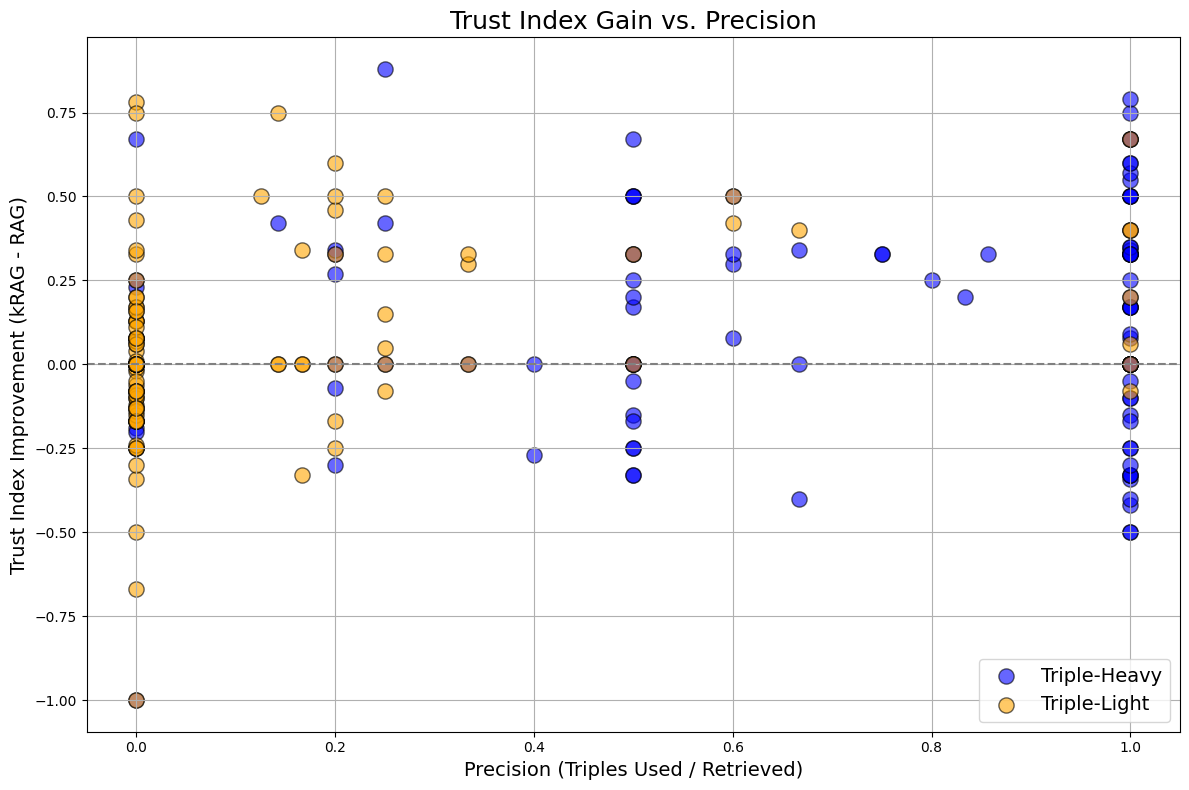

In [69]:
heavy_data, light_data = plot_filtered_scatter(evaluations, tagged_questions) 

In [70]:
# Count how many Triple-Heavy data points are above the 0 line
heavy_above_line = sum(1 for e in heavy_data if (e["trust_index_krag"] - e["trust_index_rag"]) > 0)
print(f"Blue dots above the line (Triple-Heavy): {heavy_above_line}")


Blue dots above the line (Triple-Heavy): 59


In [71]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def plot_binned_trust_index(evaluations, tagged_questions, bin_width=0.2):
    # Prepare the data
    question_set = set(q["q"] for q in tagged_questions)
    filtered_data = [e for e in evaluations if e["question"] in question_set]

    # Add category to each entry
    for e in filtered_data:
        matching_tag = next((t for t in tagged_questions if t["q"] == e["question"]), None)
        e["category"] = matching_tag["category"] if matching_tag else "Unknown"

    df = pd.DataFrame(filtered_data)

    # Create bins for precision
    bins = np.arange(0, 1.01 + bin_width, bin_width)
    labels = [f"{round(b,1)}–{round(b+bin_width,1)}" for b in bins[:-1]]
    df["precision_bin"] = pd.cut(df["precision"], bins=bins, labels=labels, include_lowest=True)

    # Calculate average trust gain per bin and category
    df["trust_gain"] = df["trust_index_krag"] - df["trust_index_rag"]
    avg_by_bin = df.groupby(["precision_bin", "category"], observed=True)["trust_gain"].mean().unstack()


    # Plotting
    avg_by_bin.plot(kind='bar', figsize=(12, 7), alpha=0.8)
    plt.axhline(0, color='gray', linestyle='--')
    plt.ylabel("Avg Trust Index Gain (kRAG - RAG)", fontsize=13)
    plt.xlabel("Precision Bins", fontsize=13)
    plt.title("Trust Index Gain vs Precision Bins", fontsize=15)
    plt.legend(title="Question Category")
    plt.tight_layout()
    plt.show()


In [72]:
# calculate dot percentages 
# Totals 
total_heavy = len(heavy_data) 
total_light = len(light_data)

# Percentages
heavy_above_pct = round((11 / total_heavy) * 100, 1)
heavy_below_pct = round((6 / total_heavy) * 100, 1)

light_above_pct = round((14 / total_light) * 100, 1)
light_below_pct = round((19 / total_light) * 100, 1)

# Print results
print(f"Triple-Heavy: {heavy_above_pct}% above, {heavy_below_pct}% below")
print(f"Triple-Light: {light_above_pct}% above, {light_below_pct}% below")


Triple-Heavy: 9.6% above, 5.2% below
Triple-Light: 12.2% above, 16.5% below


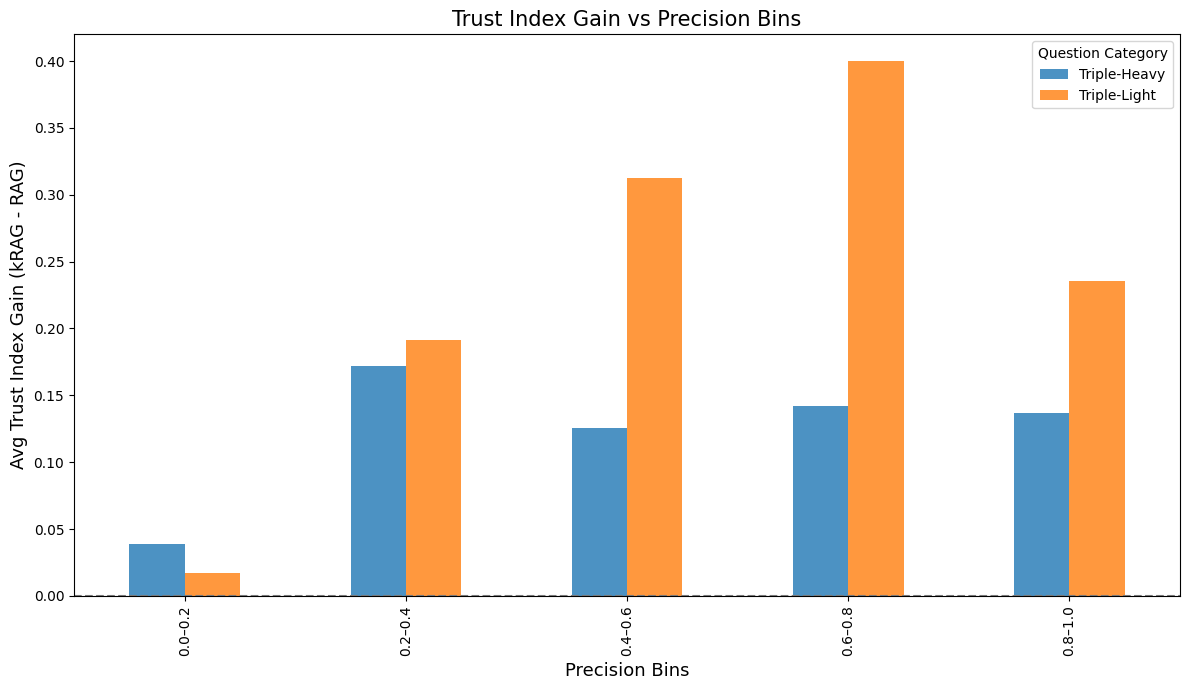

In [73]:
plot_binned_trust_index(evaluations, tagged_questions) 

## Compared to vanilla RAG (which pulls relevant documents from a vector store and injects them into the prompt), kRAG adds structured, grounded knowledge triples from a knowledge graph.

## This helps in two ways:

## Higher factual density: Triples are distilled facts, not verbose paragraphs. This increases the likelihood the LLM will generate grounded answers.

## Lower noise: Graph-based retrieval typically pulls precise relationships, whereas vector similarity can retrieve tangential context that might mislead the LLM.

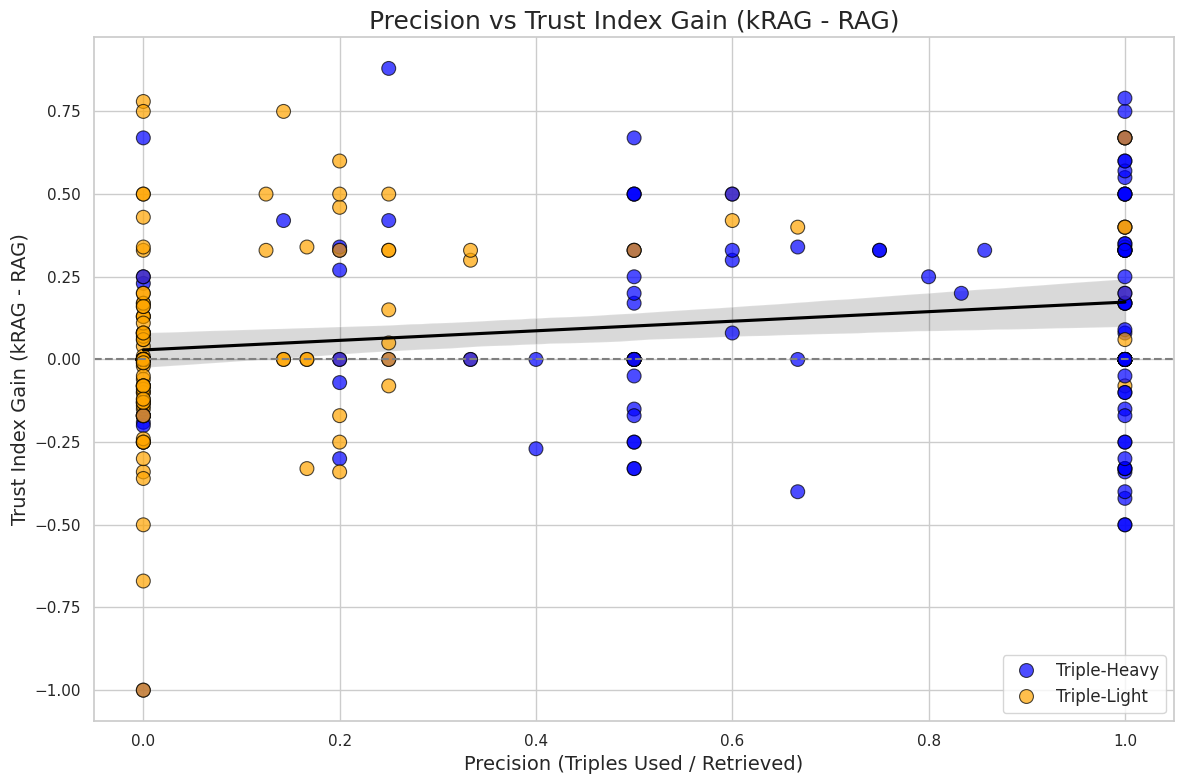

In [74]:
# scatter plot with trend line - shows how precision affects trust 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Convert evaluations + tagged data into a DataFrame
eval_df = pd.DataFrame(evaluations)

# Join category from tagged_questions
tag_map = {q["q"]: q["category"] for q in tagged_questions}
eval_df["category"] = eval_df["question"].map(tag_map)

# Compute trust index delta
eval_df["trust_delta"] = eval_df["trust_index_krag"] - eval_df["trust_index_rag"]

# Plot
plt.figure(figsize=(12, 8))
sns.set(style="whitegrid")

# Scatter plot with regression trend line
sns.regplot(
    data=eval_df,
    x="precision",
    y="trust_delta",
    scatter=False,
    line_kws={"color": "black", "label": "Trend"}
)

# Scatter colored by category
sns.scatterplot(
    data=eval_df,
    x="precision",
    y="trust_delta",
    hue="category",
    palette={"Triple-Heavy": "blue", "Triple-Light": "orange"},
    alpha=0.7,
    edgecolor="black",
    s=100
)

# Labels and style
plt.axhline(0, color="gray", linestyle="--")
plt.xlabel("Precision (Triples Used / Retrieved)", fontsize=14)
plt.ylabel("Trust Index Gain (kRAG - RAG)", fontsize=14)
plt.title("Precision vs Trust Index Gain (kRAG - RAG)", fontsize=18)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

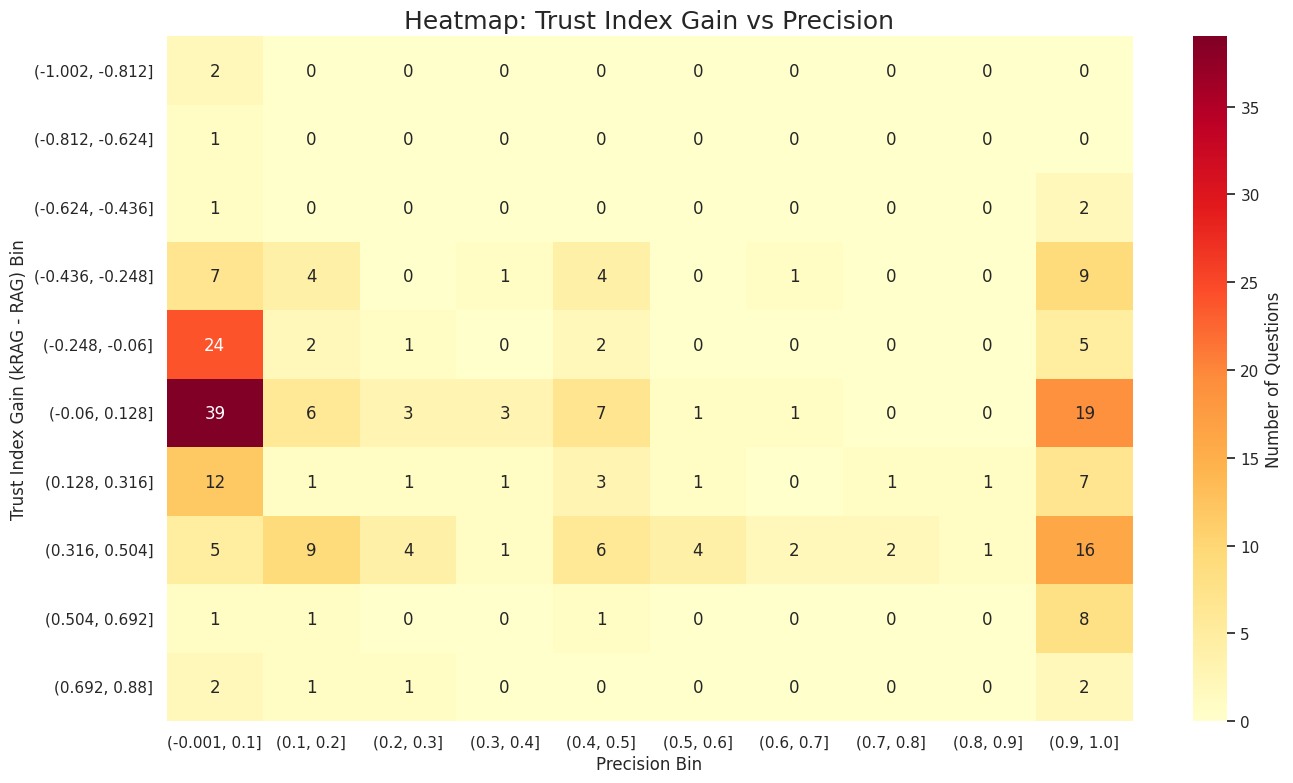

In [78]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Create DataFrame if not already present
eval_df = pd.DataFrame(evaluations)
tag_map = {q["q"]: q["category"] for q in tagged_questions}
eval_df["category"] = eval_df["question"].map(tag_map)
eval_df["trust_delta"] = eval_df["trust_index_krag"] - eval_df["trust_index_rag"]

# Bin precision and trust_delta for heatmap
eval_df["precision_bin"] = pd.cut(eval_df["precision"], bins=10)
eval_df["trust_bin"] = pd.cut(eval_df["trust_delta"], bins=10)

# Create pivot table
heatmap_data = eval_df.pivot_table(
    index="trust_bin",
    columns="precision_bin",
    values="question",  # any field just to count
    aggfunc="count",
    fill_value=0,
    observed = False
)

# Plot
plt.figure(figsize=(14, 8))
sns.heatmap(
    heatmap_data,
    annot=True,
    fmt="d",
    cmap="YlOrRd",
    cbar_kws={'label': 'Number of Questions'}
)

plt.title("Heatmap: Trust Index Gain vs Precision", fontsize=18)
plt.xlabel("Precision Bin")
plt.ylabel("Trust Index Gain (kRAG - RAG) Bin")
plt.tight_layout()
plt.show()

/tmp/ipykernel_156620/2032960610.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pivot = eval_df.groupby(["precision_bin", "gain_direction"]).size().unstack(fill_value=0)


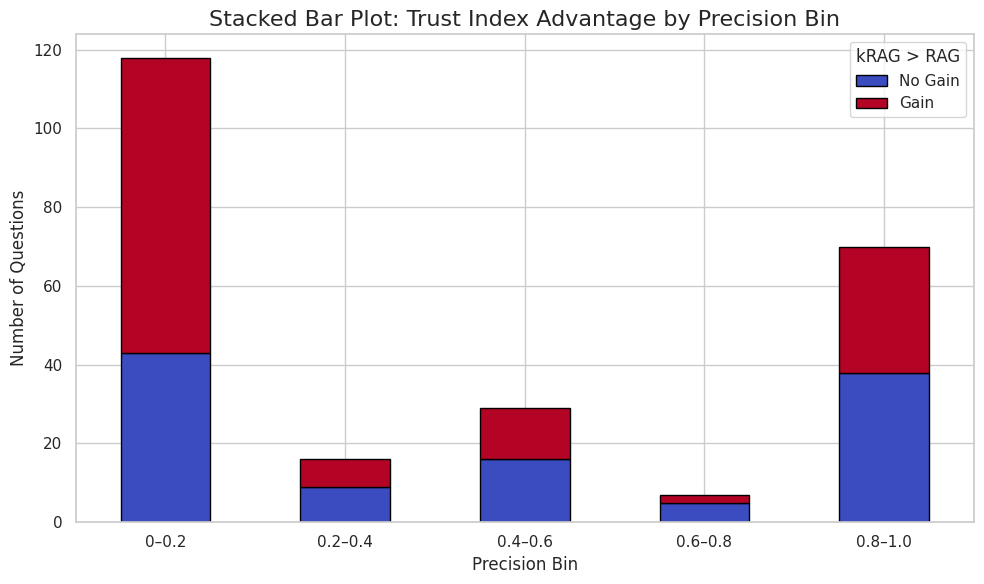

In [84]:
#  Stacked Bar Plot: Trust Index Advantage by Precision Bin 
import pandas as pd
import matplotlib.pyplot as plt

# Build DataFrame
eval_df = pd.DataFrame(evaluations)

# Add category from tagged_questions
tag_map = {q["q"]: q["category"] for q in tagged_questions}
eval_df["category"] = eval_df["question"].map(tag_map)

# Calculate trust delta
eval_df["trust_delta"] = eval_df["trust_index_krag"] - eval_df["trust_index_rag"]

# Bin precision values
bins = [0, 0.2, 0.4, 0.6, 0.8, 1.0]
labels = ["0–0.2", "0.2–0.4", "0.4–0.6", "0.6–0.8", "0.8–1.0"]
eval_df["precision_bin"] = pd.cut(eval_df["precision"], bins=bins, labels=labels, include_lowest=True)

# Count how many questions in each bin had positive or negative trust delta
eval_df["gain_direction"] = eval_df["trust_delta"].apply(lambda x: "Gain" if x > 0 else "No Gain")

# Pivot for stacked bar
pivot = eval_df.groupby(["precision_bin", "gain_direction"]).size().unstack(fill_value=0)

# Plot
pivot.plot(kind="bar", stacked=True, figsize=(10, 6), colormap="coolwarm", edgecolor='black')
plt.title("Stacked Bar Plot: Trust Index Advantage by Precision Bin", fontsize=16)
plt.xlabel("Precision Bin")
plt.ylabel("Number of Questions")
plt.xticks(rotation=0)
plt.legend(title="kRAG > RAG", labels=["No Gain", "Gain"])
plt.tight_layout()
plt.show()

/tmp/ipykernel_156620/3766749269.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=eval_df, x="category", y="trust_delta", palette={"Triple-Heavy": "blue", "Triple-Light": "orange"})


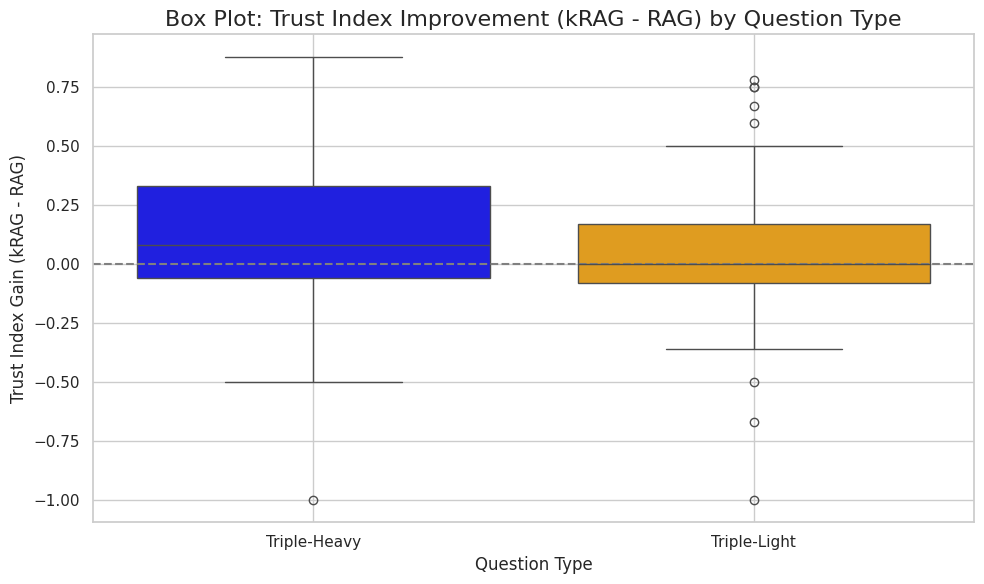

In [85]:
# Boxplot: Trust index by question category 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Build DataFrame
eval_df = pd.DataFrame(evaluations)

# Map the category from tagged questions
tag_map = {q["q"]: q["category"] for q in tagged_questions}
eval_df["category"] = eval_df["question"].map(tag_map)

# Calculate trust delta
eval_df["trust_delta"] = eval_df["trust_index_krag"] - eval_df["trust_index_rag"]

# Plot
plt.figure(figsize=(10, 6))
sns.boxplot(data=eval_df, x="category", y="trust_delta", palette={"Triple-Heavy": "blue", "Triple-Light": "orange"})

plt.axhline(0, color="gray", linestyle="--")
plt.title("Box Plot: Trust Index Improvement (kRAG - RAG) by Question Type", fontsize=16)
plt.xlabel("Question Type")
plt.ylabel("Trust Index Gain (kRAG - RAG)")
plt.grid(True)
plt.tight_layout()
plt.show()
